## Import libraries

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import vgg16, Xception
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import pickle
import time
import os

## Load data

In [8]:
data_gen = ImageDataGenerator(rescale=1./255)

data_gen = data_gen.flow_from_directory(
    directory='Data/train/', 
    target_size=(224, 224),
    batch_size=5232
)

X = data_gen[0][0]
y = data_gen[0][1]

Found 5232 images belonging to 2 classes.


## Visualize data

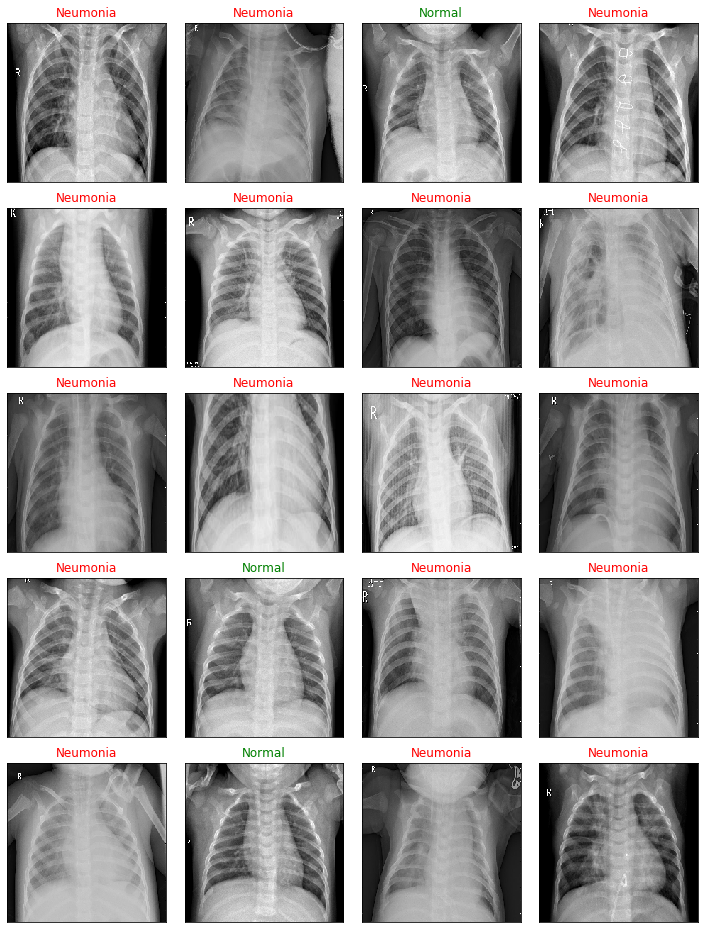

In [10]:
fig, axs = plt.subplots(5, 4, figsize=(10, 13))

for i, ax in enumerate(axs.flat):
    ax.imshow(X[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Normal" if y[i,0] == 1 else "Neumonia" ,
                 color='green' if y[i,0] == 1 else 'red', 
                 fontsize=12)
plt.tight_layout()
plt.show()

## Model VGG16

In [11]:
vgg16 = vgg16.VGG16()

In [12]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Extract convolutional layers

In [13]:
model_vgg16 = Sequential()
for i in range(19):
    model_vgg16.add(vgg16.get_layer(index=i))

In [14]:
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

## Extract image features with vgg16 model

In [ ]:
X_vgg16 = model_vgg16.predict(X)

In [ ]:
with open("Data/data_vgg16_train.pickle", "wb") as f:
    pickle.dump({'x':X_vgg16, 'y':y}, f)

## Load processed data

In [15]:
with open("Data/data_vgg16_train.pickle", "rb") as f:
    data = pickle.load(f)

In [16]:
x = data['x']
y = data['y']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [17]:
print('Input size: ', x.shape)
print('Target size: ', y.shape)

Input size:  (5232, 7, 7, 512)
Target size:  (5232, 2)


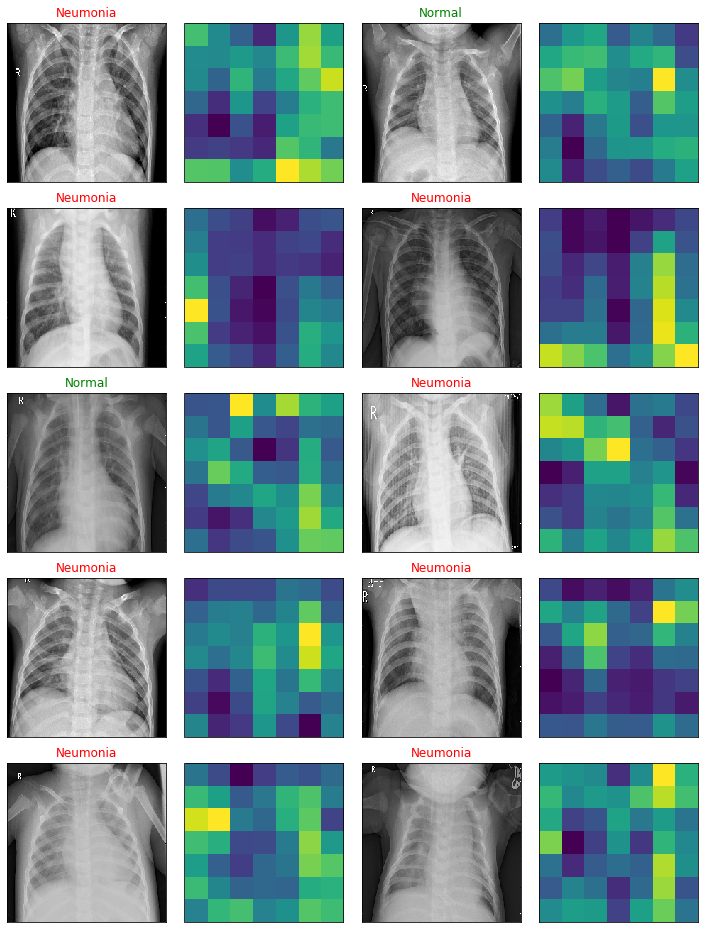

In [18]:
fig, axs = plt.subplots(5, 4, figsize=(10, 13))

for i, ax in enumerate(axs.flat):
    if i%2 == 0:
        ax.imshow(X[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("Normal" if y[i,0] == 1 else "Neumonia" ,
                     color='green' if y[i,0] == 1 else 'red', 
                     fontsize=12)
    else:
        ax.imshow(np.sum(x[i-1], axis=2))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

## Classification of feature maps using CNNs

In [19]:
def model_cnn(conv_filters, kernel_size, dense_units):
    model = Sequential()
    model.add(Input(shape=(7,7,512)))
    model.add(Conv2D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dense(units=2, activation='softmax'))
    return model

In [33]:
def train_model(conv_filters, kernel_size, dense_units):
    
    n_iter = len(conv_filters)*len(kernel_size)*len(dense_units)
    iter_ = 0
    t1 = time.time()
    models = {}
    history = {}
    
    for conv_filters_ in conv_filters:
        for kernel_size_ in kernel_size:
            for dense_units_ in dense_units:
                
                bar = "="*int(30*(iter_/n_iter)) + " "*(30 - int(30*(iter_/n_iter)))
                info = f"| Filters: {conv_filters_} | Kernel: {kernel_size_} | Dense: {dense_units_} | "
                print(f" [{bar}] {int((iter_/n_iter)*100)} % {info}", end="\r")
                
                model_file_name = f"./Models/model_cnn_{conv_filters_}_conv_filters_{kernel_size_}_kernel_size_{dense_units_}_dense_units.h5"
                model_file_name = model_file_name.replace(', ','x').replace('(','').replace(')','')
                model = model_cnn(conv_filters_, kernel_size_, dense_units_)
                model.compile(loss='CategoricalCrossentropy', optimizer='Adam', metrics=['accuracy'])
                checkpoint = ModelCheckpoint(model_file_name, monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)  
                h = model.fit(x_train, y_train, epochs=16, batch_size=256, validation_split=0.2, verbose=0, callbacks=[checkpoint])
                
                model_name = f"{conv_filters_}-{kernel_size_}-{dense_units_}"
                model_name = model_name.replace(', ','x').replace('(','').replace(')','')
                history[model_name] = h.history
                models[model_name] = model
                
                iter_ += 1
                
    t2 = time.time()
    bar = "="*30
    print(f" [{bar}] 100 % | Time: {int(t2-t1)} seg. | {n_iter} tasks completed successfully ", end="\r")
    
    return models, history

In [34]:
conv_filters = [16, 32, 64]
kernel_size = [(2,2), (3,3)]
dense_units = [32, 64, 128]

models, history = train_model(conv_filters, kernel_size, dense_units)

## Plotting metrics 

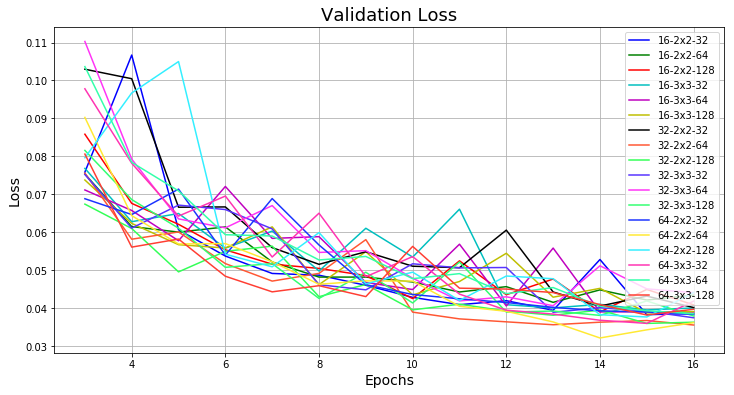

In [62]:
colors = [
    'b', 'g', 'r', 'c', 'm', 'y', 'k', '#FF5733', '#33FF57', '#5733FF', 
    '#FF33F6', '#33FF71', '#1A33FF', '#FFE933', '#33EFFF', '#FF33B2', 
    '#33FFAA', '#FF3E33', '#33FFC1'
]

plt.figure(figsize=(12,6))
for i,h in enumerate(history):
    plt.plot(np.arange(3,17,1), history[h]['val_loss'][2:], label=h, color=colors[i])
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Validation Loss", fontsize=18)
plt.grid()
plt.legend()
plt.show()

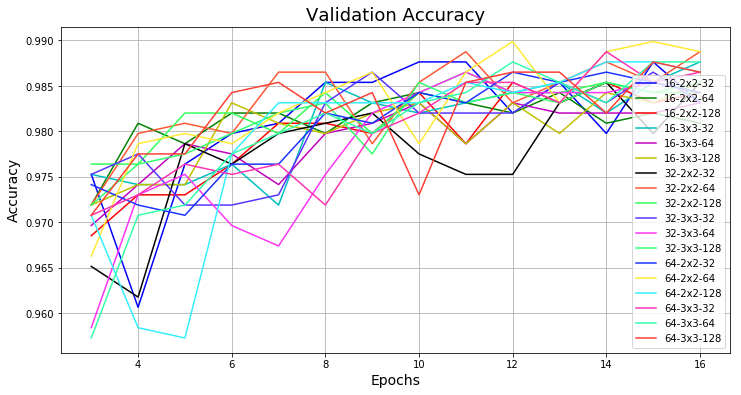

In [63]:
plt.figure(figsize=(12,6))
for i, h in enumerate(history):
    plt.plot(np.arange(3,17,1), history[h]['val_accuracy'][2:], label=h, color=colors[i])
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Validation Accuracy", fontsize=18)
plt.grid()
plt.legend()
plt.show()

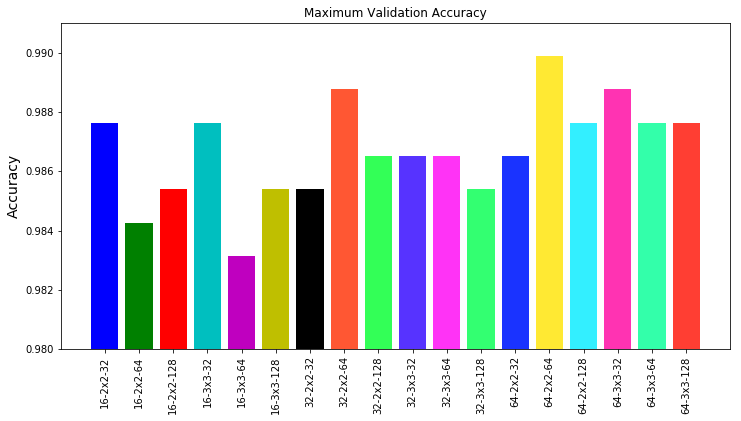

In [82]:
max_accuracy = []
names = []
for i,h in enumerate(history):
    max_accuracy.append(np.max(history[h]['val_accuracy']))
    names.append(h)
plt.figure(figsize=(12,6))
plt.bar(names, np.array(max_accuracy), color=colors[0:18])
plt.ylim(0.98,0.991)
plt.xticks(rotation=90)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Maximum Validation Accuracy")
plt.show()

## Evaluate models

In [84]:
os.listdir("./Models/")

['model_cnn_16_conv_filters_2x2_kernel_size_128_dense_units.h5',
 'model_cnn_16_conv_filters_2x2_kernel_size_32_dense_units.h5',
 'model_cnn_16_conv_filters_2x2_kernel_size_64_dense_units.h5',
 'model_cnn_16_conv_filters_3x3_kernel_size_128_dense_units.h5',
 'model_cnn_16_conv_filters_3x3_kernel_size_32_dense_units.h5',
 'model_cnn_16_conv_filters_3x3_kernel_size_64_dense_units.h5',
 'model_cnn_32_conv_filters_2x2_kernel_size_128_dense_units.h5',
 'model_cnn_32_conv_filters_2x2_kernel_size_32_dense_units.h5',
 'model_cnn_32_conv_filters_2x2_kernel_size_64_dense_units.h5',
 'model_cnn_32_conv_filters_3x3_kernel_size_128_dense_units.h5',
 'model_cnn_32_conv_filters_3x3_kernel_size_32_dense_units.h5',
 'model_cnn_32_conv_filters_3x3_kernel_size_64_dense_units.h5',
 'model_cnn_64_conv_filters_2x2_kernel_size_128_dense_units.h5',
 'model_cnn_64_conv_filters_2x2_kernel_size_32_dense_units.h5',
 'model_cnn_64_conv_filters_2x2_kernel_size_64_dense_units.h5',
 'model_cnn_64_conv_filters_3x3_ker